In [1]:
import copernicusmarine 
import xarray
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Dataset 30 anys

In [2]:
ds =copernicusmarine.open_dataset(dataset_id='cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D',
                                  #minimum_longitude =,
                                  #maximum_longitude = ,
                                  #minimum_latitude = ,
                                  #maximum_latitude = ,
                                  )  

INFO - 2024-08-02T22:49:03Z - Dataset version was not specified, the latest one was selected: "202112"
INFO - 2024-08-02T22:49:03Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-02T22:49:07Z - Service was not specified, the default one was selected: "arco-geo-series"
username:password:

In [3]:
ds

<xarray.Dataset>
Dimensions:         (time: 11115, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    lat_bnds        (latitude, nv) float32 ...
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
    lon_bnds        (longitude, nv) float32 ...
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2023-06-07
Data variables:
    adt             (time, latitude, longitude) float64 ...
    err_sla         (time, latitude, longitude) float64 ...
    err_ugosa       (time, latitude, longitude) float64 ...
    err_vgosa       (time, latitude, longitude) float64 ...
    flag_ice        (time, latitude, longitude) float64 ...
    sla             (time, latitude, longitude) float64 ...
    tpa_correction  (time) float64 ...
    ugos            (time, latitude, longitude) float64 ...
    ugosa           (time, latitude, longitude) float64 ...
    vgos            (time, latitude, longitude) float64 ...
    vgosa           (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

### Generem un llist de dates 

In [4]:
dates = pd.date_range(start='1993-01-01', end='2023-06-07')

# Convert to list of strings in the format YYYY-MM-DD
date_strings = dates.strftime('%Y-%m-%d').tolist()

### Càlcul EKE mitjà

In [6]:
# Create empty arrays to store the ugosa and vgosa data for each date
EKE_sum = np.zeros((len(ds.latitude), len(ds.longitude)))
ρ = 1025 

# Loop through each date and extract the ugosa and vgosa data
for i in range(len(date_strings)):
    ds_sel = ds.sel(time=date_strings[i])
    ugosa = ds_sel['ugosa'].values
    vgosa = ds_sel['vgosa'].values

    EKE = 0.5 * ρ * ((ugosa**2) + (vgosa**2))
    EKE_sum += EKE

# Calculate the mean speed and kinetic energy
mean_EKE = EKE_sum / len(date_strings)

#save the array
np.save('mean_EKE.npy', mean_EKE)

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\1383718751.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmp, norm=norm))


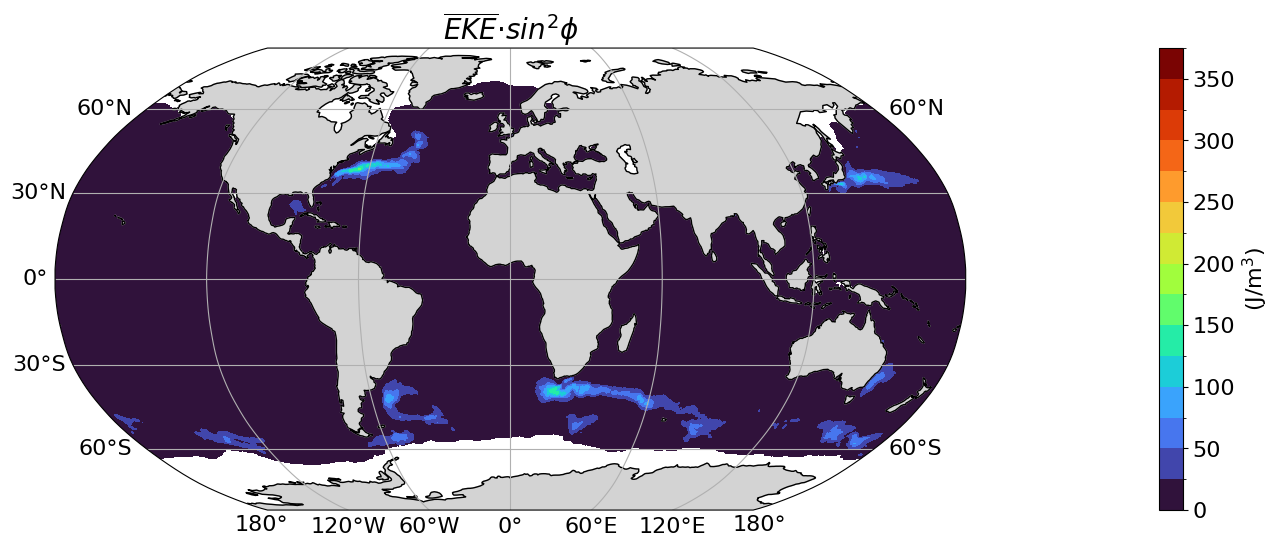

In [172]:
import matplotlib as mpl
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature


longitude, latitude = np.meshgrid(ds.longitude, ds.latitude)
'''


plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.COASTLINE)
ax.gridlines()

bounds = np.arange(0, 400, 25)
cmp = plt.get_cmap('turbo')
norm = mpl.colors.BoundaryNorm(bounds, cmp.N)

contour_plot = ax.contourf(longitude, latitude, mean_EKE, bounds, cmap=cmp, norm=norm, transform=ccrs.PlateCarree())

plt.colorbar(mpl.cm.ScalarMappable(cmap=cmp, norm=norm))

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('EKE from 1993 to 2023')
plt.show()
'''
plt.figure(figsize=(50, 6))
f = (np.sin(latitude * np.pi / 180)) ** 2

bounds = np.arange(0, 400, 25)
cmp = plt.get_cmap('turbo')
norm = mpl.colors.BoundaryNorm(bounds, cmp.N)

ax = plt.axes(projection=ccrs.Robinson())
gl = ax.gridlines(draw_labels=True)

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

contour_plot = ax.contourf(longitude, latitude, mean_EKE * f, bounds, cmap=cmp, norm=norm, transform=ccrs.PlateCarree())

cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmp, norm=norm))
cbar.set_label(r'(J/m$^3$)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title(r'$\overline{EKE} · sin^2\phi$', fontsize=20)
plt.show()

## KE Feta amb la mitjana del mòdul de la velocitat 
$$ KE = \frac{1}{2} \rho (\bar{u}^2 + \bar{v}^2) $$


In [9]:
# Calculate the kinetic energy of the velocity mean
ugos_sum = np.zeros((len(ds.latitude), len(ds.longitude)))
vgos_sum = np.zeros((len(ds.latitude), len(ds.longitude)))

for i in range(len(date_strings)):
    ds_sel = ds.sel(time=date_strings[i])
    ugos = ds_sel['ugos'].values
    vgos = ds_sel['vgos'].values

    ugos_sum += ugos
    vgos_sum += vgos

ugos_mean = ugos_sum / len(date_strings)
vgos_mean = vgos_sum / len(date_strings)

mean_KE = 0.5* ρ * (ugos_mean**2 + vgos_mean**2)

In [10]:
# save the array
np.save('mean_KE.npy', mean_KE)

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\635300856.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))


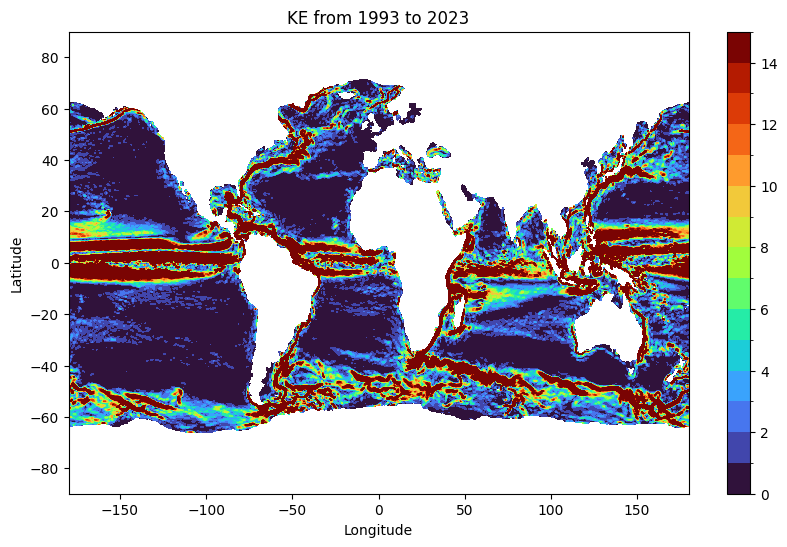

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\635300856.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmp, norm=norm))


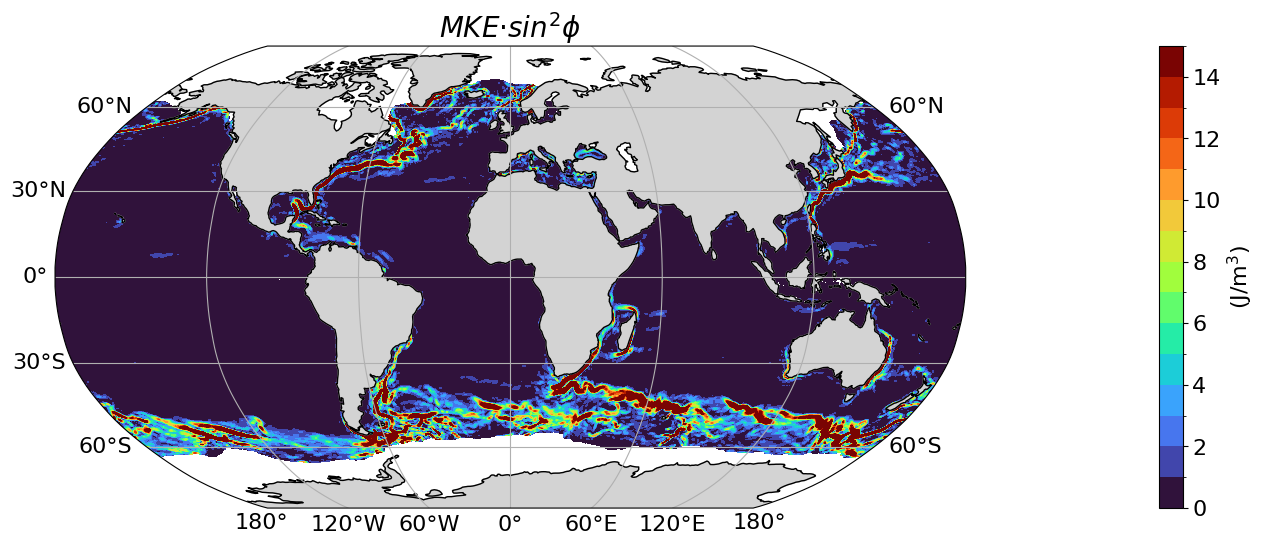

In [173]:
longitude, latitude = np.meshgrid(ds.longitude, ds.latitude)


plt.figure(figsize=(10, 6))

bounds = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,1000]
cmp = plt.get_cmap('turbo')
norm = mpl.colors.BoundaryNorm(bounds,cmp.N)

plt.contourf(longitude, latitude,mean_KE, bounds,cmap= cmp, norm = norm)



plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))
#plt.colorbar(contour_plot, label='Mean Kinetic Energy (J/m³)', extend='both')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KE from 1993 to 2023')
plt.show()


plt.figure(figsize=(50, 6))
f = (np.sin(latitude * np.pi / 180)) ** 2

ax = plt.axes(projection=ccrs.Robinson())

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

contour_plot = ax.contourf(longitude, latitude, mean_KE * f, bounds, cmap=cmp, norm=norm, transform=ccrs.PlateCarree())

cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmp, norm=norm))
cbar.set_label(r'(J/m$^3$)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title(r'$MKE · sin^2\phi$', fontsize=20)
plt.show()

# Mean KE

In [12]:
# Create empty arrays to store the ugos and vgos data for each date

KE_sum = np.zeros((len(ds.latitude), len(ds.longitude)))


# Loop through each date and extract the ugos and vgos data
for i in range(len(date_strings)):
    ds_sel_total = ds.sel(time=date_strings[i])
    ugos = ds_sel_total['ugos'].values
    vgos = ds_sel_total['vgos'].values

    KE_total = 0.5 * ρ * (ugos**2 + vgos**2)

    KE_sum += KE_total


# Calculate the mean speed and kinetic energy for the year 2022

mean_KE_total = KE_sum / len(date_strings)

#save the array
np.save('mean_KE_total.npy', mean_KE_total)

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\3421536455.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))


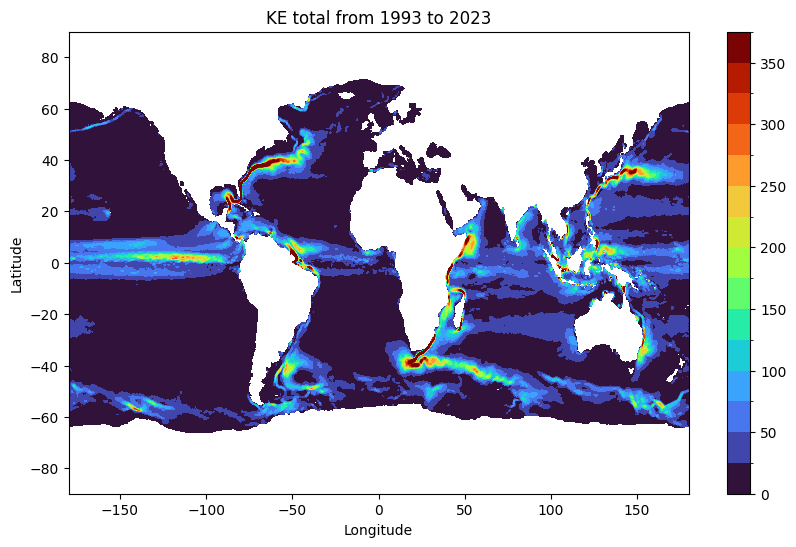

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\3421536455.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))


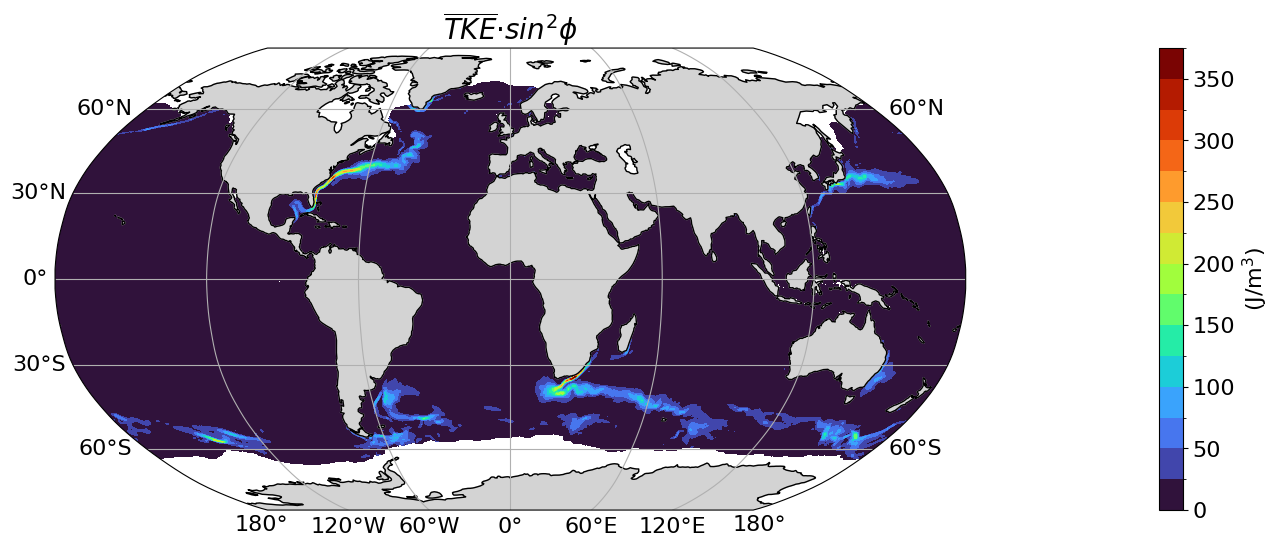

In [182]:
longitude, latitude = np.meshgrid(ds.longitude, ds.latitude)


plt.figure(figsize=(10, 6))

bounds = [0,25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350,1000]
cmp = plt.get_cmap('turbo')
norm = mpl.colors.BoundaryNorm(bounds,cmp.N)

plt.contourf(longitude, latitude,mean_KE_total, bounds,cmap= cmp, norm = norm)



plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))
#plt.colorbar(contour_plot, label='Mean Kinetic Energy (J/m³)', extend='both')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KE total from 1993 to 2023')
plt.show()


plt.figure(figsize=(50, 6))
f = (np.sin(latitude*np.pi/180))**2



cmp = plt.get_cmap('turbo')
norm = mpl.colors.BoundaryNorm(bounds,cmp.N)

ax = plt.axes(projection=ccrs.Robinson())

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

contour_plot = ax.contourf(longitude, latitude,mean_KE_total*f, bounds,cmap= cmp, norm = norm, transform=ccrs.PlateCarree())


cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))
cbar.set_label('(J/m$^3$)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title(r'$\overline{TKE} · sin^2\phi$', fontsize=20)
plt.show()

## Ratio

In [144]:
ratio = mean_EKE/mean_KE

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\1665510058.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmp, norm=norm))


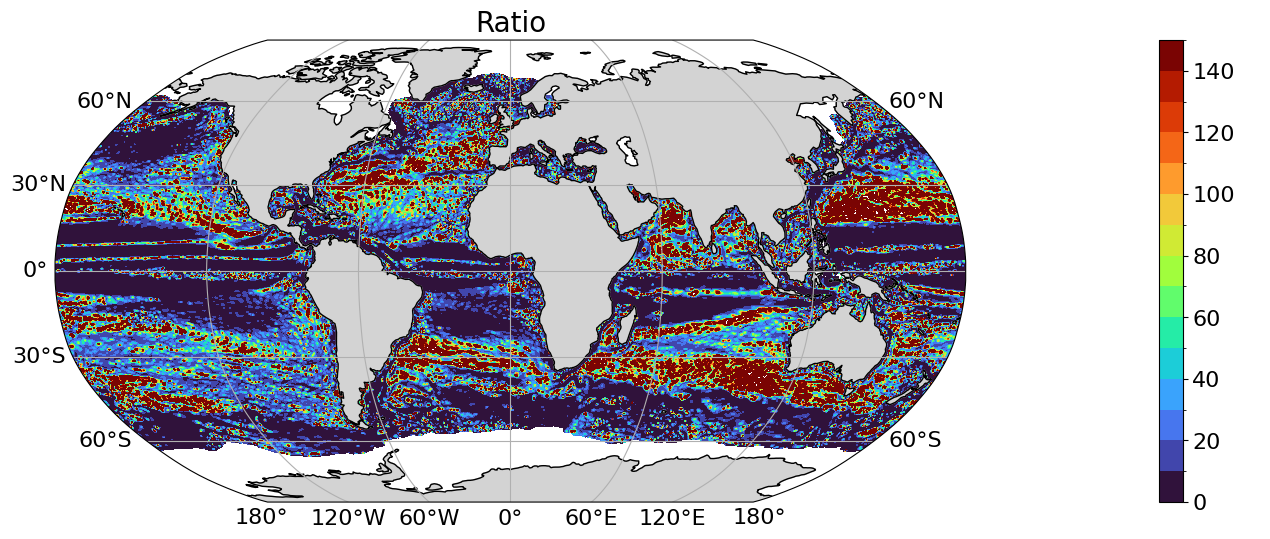

In [176]:
plt.figure(figsize=(50, 6))

bounds = [0,10,20,30,40,50,60,70,80,90,100,110,120,130, 140, 1000]
cmp = plt.get_cmap('turbo')
norm = mpl.colors.BoundaryNorm(bounds,cmp.N)



ax = plt.axes(projection=ccrs.Robinson())

gl = ax.gridlines(draw_labels=True)
land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

contour_plot = ax.contourf(longitude, latitude, ratio, bounds, cmap=cmp, norm=norm, transform=ccrs.PlateCarree())

cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmp, norm=norm))
cbar.set_label('     ', fontsize=16)
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title('Ratio', fontsize=20)
plt.show()

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\2763350257.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))


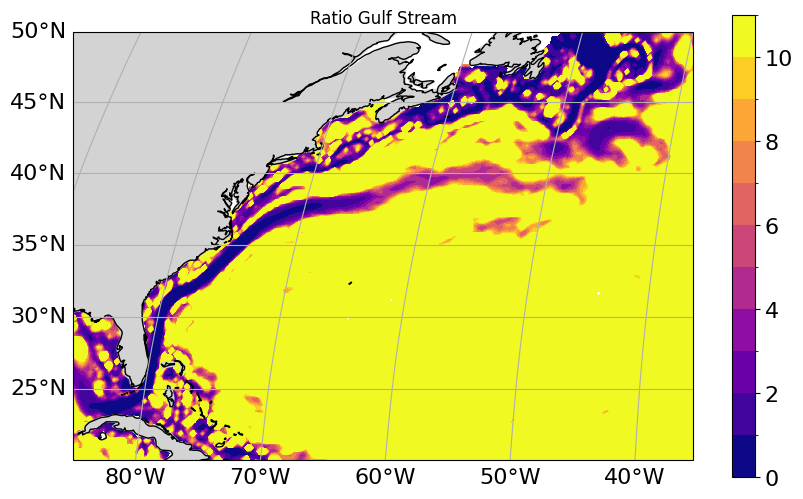

"\n\nplt.figure(figsize=(10, 6))\n\nax = plt.axes(projection=ccrs.Robinson())\n\ngl = ax.gridlines(draw_labels=True)\nland = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')\nax.add_feature(land)\nax.add_feature(cfeature.COASTLINE)\n\ngl.top_labels = False\ngl.right_labels = False\ngl.xlabel_style = {'size': 16}\ngl.ylabel_style = {'size': 16}\n\ncontour_plot = ax.contourf(longitude, latitude,ratio, bounds,cmap= cmp, norm = norm, transform=ccrs.PlateCarree())\n\ncbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))\ncbar.ax.tick_params(labelsize=16)\n\nax.set_xlabel('Longitude', fontsize=14)\nax.set_ylabel('Latitude', fontsize=14)\nplt.title('Ratio ...')\n\n# Set zoom limits\nzoom_xlim = (110, 170)  \nzoom_ylim = (20, 50)    \nax.set_extent([zoom_xlim[0], zoom_xlim[1], zoom_ylim[0], zoom_ylim[1]], crs=ccrs.PlateCarree())\nplt.show()\n\n\n\n\n\nplt.figure(figsize=(20, 6))\n\nax = plt.axes(projection=ccrs.Robinson())\n\ngl = 

In [193]:
#zoom
plt.figure(figsize=(10, 6))

bounds = [0,1,2,3,4,5,6,7,8,9,10,100000]
cmp = plt.get_cmap('plasma')
norm = mpl.colors.BoundaryNorm(bounds,cmp.N)

ax = plt.axes(projection=ccrs.Robinson())

gl = ax.gridlines(draw_labels=True)
land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)


gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

contour_plot = ax.contourf(longitude, latitude,ratio, bounds,cmap= cmp, norm = norm, transform=ccrs.PlateCarree())

cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title('Ratio Gulf Stream')

# Set zoom limits
zoom_xlim = (-85, -40)  
zoom_ylim = (20, 50)    
ax.set_extent([zoom_xlim[0], zoom_xlim[1], zoom_ylim[0], zoom_ylim[1]], crs=ccrs.PlateCarree())
plt.show()


'''

plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.Robinson())

gl = ax.gridlines(draw_labels=True)
land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

contour_plot = ax.contourf(longitude, latitude,ratio, bounds,cmap= cmp, norm = norm, transform=ccrs.PlateCarree())

cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title('Ratio ...')

# Set zoom limits
zoom_xlim = (110, 170)  
zoom_ylim = (20, 50)    
ax.set_extent([zoom_xlim[0], zoom_xlim[1], zoom_ylim[0], zoom_ylim[1]], crs=ccrs.PlateCarree())
plt.show()





plt.figure(figsize=(20, 6))

ax = plt.axes(projection=ccrs.Robinson())

gl = ax.gridlines(draw_labels=True)
land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)


gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

contour_plot = ax.contourf(longitude, latitude,ratio, bounds,cmap= cmp, norm = norm, transform=ccrs.PlateCarree())

cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))
cbar.ax.tick_params(labelsize=16)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title('Ratio Gulf Stream')

zoom_xlim = (-60, 80)  
zoom_ylim = (-60, -30)    
ax.set_extent([zoom_xlim[0], zoom_xlim[1], zoom_ylim[0], zoom_ylim[1]], crs=ccrs.PlateCarree())
plt.show()
'''

# Càlcul %

In [59]:
mean_KE_total_MEAN = np.nanmean(mean_KE_total)
mean_KE_MEAN = np.nanmean(mean_KE)
mean_EKE_MEAN = np.nanmean(mean_EKE)

In [64]:
print('KE mean / KE total *100 = ', mean_KE_MEAN/mean_KE_total_MEAN *100,'%')
print('EKE / KE total *100 = ', mean_EKE_MEAN/mean_KE_total_MEAN*100,'%' )
print('KE mean / EKE *100 = ',mean_KE_MEAN/mean_EKE_MEAN,'%')


KE mean / KE total *100 =  24.518773017672057 %
EKE / KE total *100 =  76.00161540077045 %
KE mean / EKE *100 =  0.3226085773095752 %


# KE total / KE mean i KE total / EKE

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\1085383975.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))


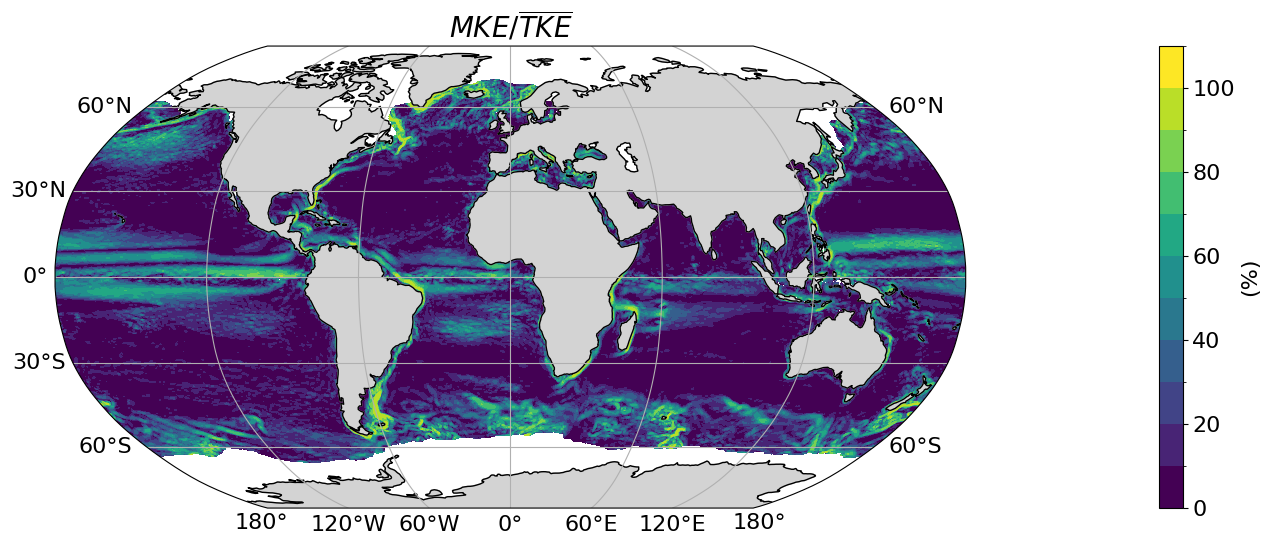

C:\Users\mrpal\AppData\Local\Temp\ipykernel_18176\1085383975.py:59: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))


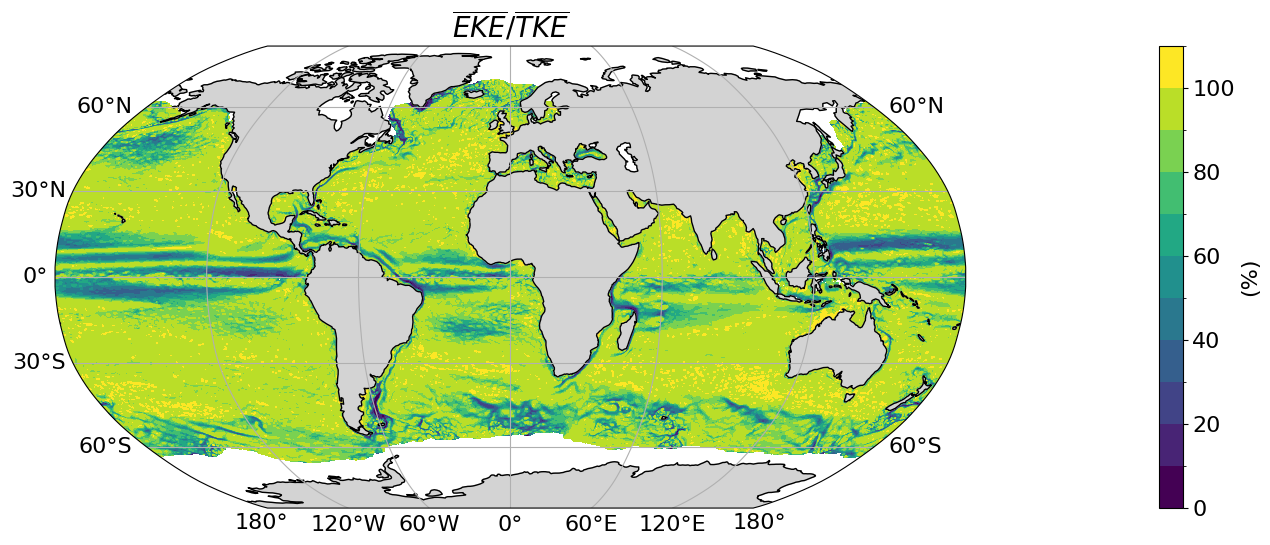

In [174]:
plt.figure(figsize=(50, 6))

bounds = [0,10,20,30,40,50,60,70,80,90,100,1000]
cmp = plt.get_cmap('viridis')
norm = mpl.colors.BoundaryNorm(bounds,cmp.N)

ax = plt.axes(projection=ccrs.Robinson())

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}


contour_plot = ax.contourf(longitude, latitude,mean_KE/mean_KE_total*100, bounds,cmap= cmp, norm = norm,transform=ccrs.PlateCarree())


cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))
cbar.set_label('(%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)


ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

plt.title(r'$MKE$/$\overline{TKE}$', fontsize =20)
plt.show()






plt.figure(figsize=(50, 6))

ax = plt.axes(projection=ccrs.Robinson())


land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray')
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}



plt.contourf(longitude, latitude,mean_EKE/mean_KE_total*100, bounds,cmap= cmp, norm = norm,transform=ccrs.PlateCarree())


cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = cmp, norm = norm))
cbar.set_label('(%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)


ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

plt.title(r'$\overline{EKE}$/$\overline{TKE}$', fontsize =20)
plt.show()